# Data preparation for StorSeismic fine-tuning

This notebook contains data preparation for fine-tuning of StorSeismic (Harsuko and Alkhalifah, 2022). Here, we will prepare a dataset for denoising and velocity estimation task.

## Load required modules

In [43]:
import torch
from snist.dataset import SNIST
import os
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np

import storseismic.utils as utils

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Load data

### Load/download data from SNIST

https://github.com/LukasMosser/SNIST

In [46]:
snist_train = SNIST('./', train=True, download=True) # Training data
snist_test = SNIST('./', train=False, download=True, noise=0) # Testing data

  0%|          | 0/13008128 [00:00<?, ?it/s]

  0%|          | 0/21728 [00:00<?, ?it/s]

  0%|          | 0/3252128 [00:00<?, ?it/s]

  0%|          | 0/5528 [00:00<?, ?it/s]

  0%|          | 0/3252128 [00:00<?, ?it/s]

  0%|          | 0/3252128 [00:00<?, ?it/s]

Processing...
Done!


### Create data dictionary

We create four instances in the dictionary:
- <code>inputs_embeds</code> for the noisy data
- <code>labels</code> for the clean data
- <code>vel</code> for the velocities
- <code>index</code> to store the original, unaugmented indices of the data
- <code>noise_lvl</code> to store the noise level

In [3]:
snist_train_mlm, snist_test_mlm = {}, {}
for data, data_mlm in zip([snist_train, snist_test], 
                [snist_train_mlm, snist_test_mlm]):
    data_mlm['inputs_embeds'] = data.train_data.detach().clone()
    data_mlm['labels'] =  data.train_data.detach().clone()
    data_mlm['vel'] = data.targets.detach().clone()
    data_mlm['index'] = torch.arange(data.train_data.shape[0])
    data_mlm['noise_lvl'] = torch.zeros(data.train_data.shape[0])

/home/randycm/anaconda3/envs/transformers-2/lib/python3.8/site-packages/snist/dataset.py:67: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
# Some cleanup (swap time and offset axis, and remove extra axis)

for data in snist_train_mlm, snist_test_mlm:
    for key in data.keys():
        if key not in ['index', 'vel', 'noise_lvl']:
            data[key] = data[key].swapaxes(2, 3)
            data[key] = data[key].squeeze()
            
print("Training data shape: ", snist_train_mlm['inputs_embeds'].shape)
print("Testing data shape: ", snist_test_mlm['inputs_embeds'].shape)

Training data shape:  torch.Size([600, 20, 271])
Testing data shape:  torch.Size([150, 20, 271])


## Pre-processing and augmentation

### Scale the data into the range [-1, 1]

In [5]:
vmin_all = torch.min(snist_train_mlm['inputs_embeds'])
vmax_all = torch.max(snist_train_mlm['inputs_embeds'])

for data_mlm in [snist_train_mlm, snist_test_mlm]:
    data_mlm['inputs_embeds'] = -1 + (2 * (data_mlm['inputs_embeds'] - vmin_all) / (vmax_all - vmin_all))
    data_mlm['labels'] = -1 + (2 * (data_mlm['labels'] - vmin_all) / (vmax_all - vmin_all))
    
vmin_all = -1
vmax_all = 1

### Add noise to data

In [6]:
def add_noise(input_data, sigma=1):
    output_data = input_data.detach().clone()
    output_data = output_data + (torch.randn(input_data.size()) * sigma * torch.sqrt(torch.var(input_data)))
    
    return output_data

# Add 1-sigma Gaussian noise to 40% data
snist_train_mlm['inputs_embeds'][120:360] = add_noise(snist_train_mlm['inputs_embeds'][120:360], sigma=1)
snist_train_mlm['noise_lvl'][120:360] = 1
snist_test_mlm['inputs_embeds'][30:90] = add_noise(snist_test_mlm['inputs_embeds'][30:90], sigma=1)
snist_test_mlm['noise_lvl'][30:90] = 1

# Add 2-sigma Gaussian noise to 40% data
snist_train_mlm['inputs_embeds'][360:] = add_noise(snist_train_mlm['inputs_embeds'][360:], sigma=2)
snist_train_mlm['noise_lvl'][360:] = 2
snist_test_mlm['inputs_embeds'][90:] = add_noise(snist_test_mlm['inputs_embeds'][90:], sigma=2)
snist_test_mlm['noise_lvl'][90:] = 2

### Apply polarity reversal

Polarity reversal augmentation: We reverse the polarity of the data, as if we use a reversed polarity of the source. This is done simply by multiplying the data by -1.

In [7]:
polarity_change = True

if polarity_change:
    for data in snist_train_mlm, snist_test_mlm:
        augmented = data.copy()
        augmented['inputs_embeds'] = augmented['inputs_embeds'] * -1
        augmented['labels'] = augmented['labels'] * -1
        for key in augmented.keys():
            data[key] = torch.cat((data[key], augmented[key]), 0)

## Finalize

### Wrap in a custom Pytorch dataset

In [8]:
train_data = utils.SSDataset(snist_train_mlm)
test_data = utils.SSDataset(snist_test_mlm)

### Visualize created dataset

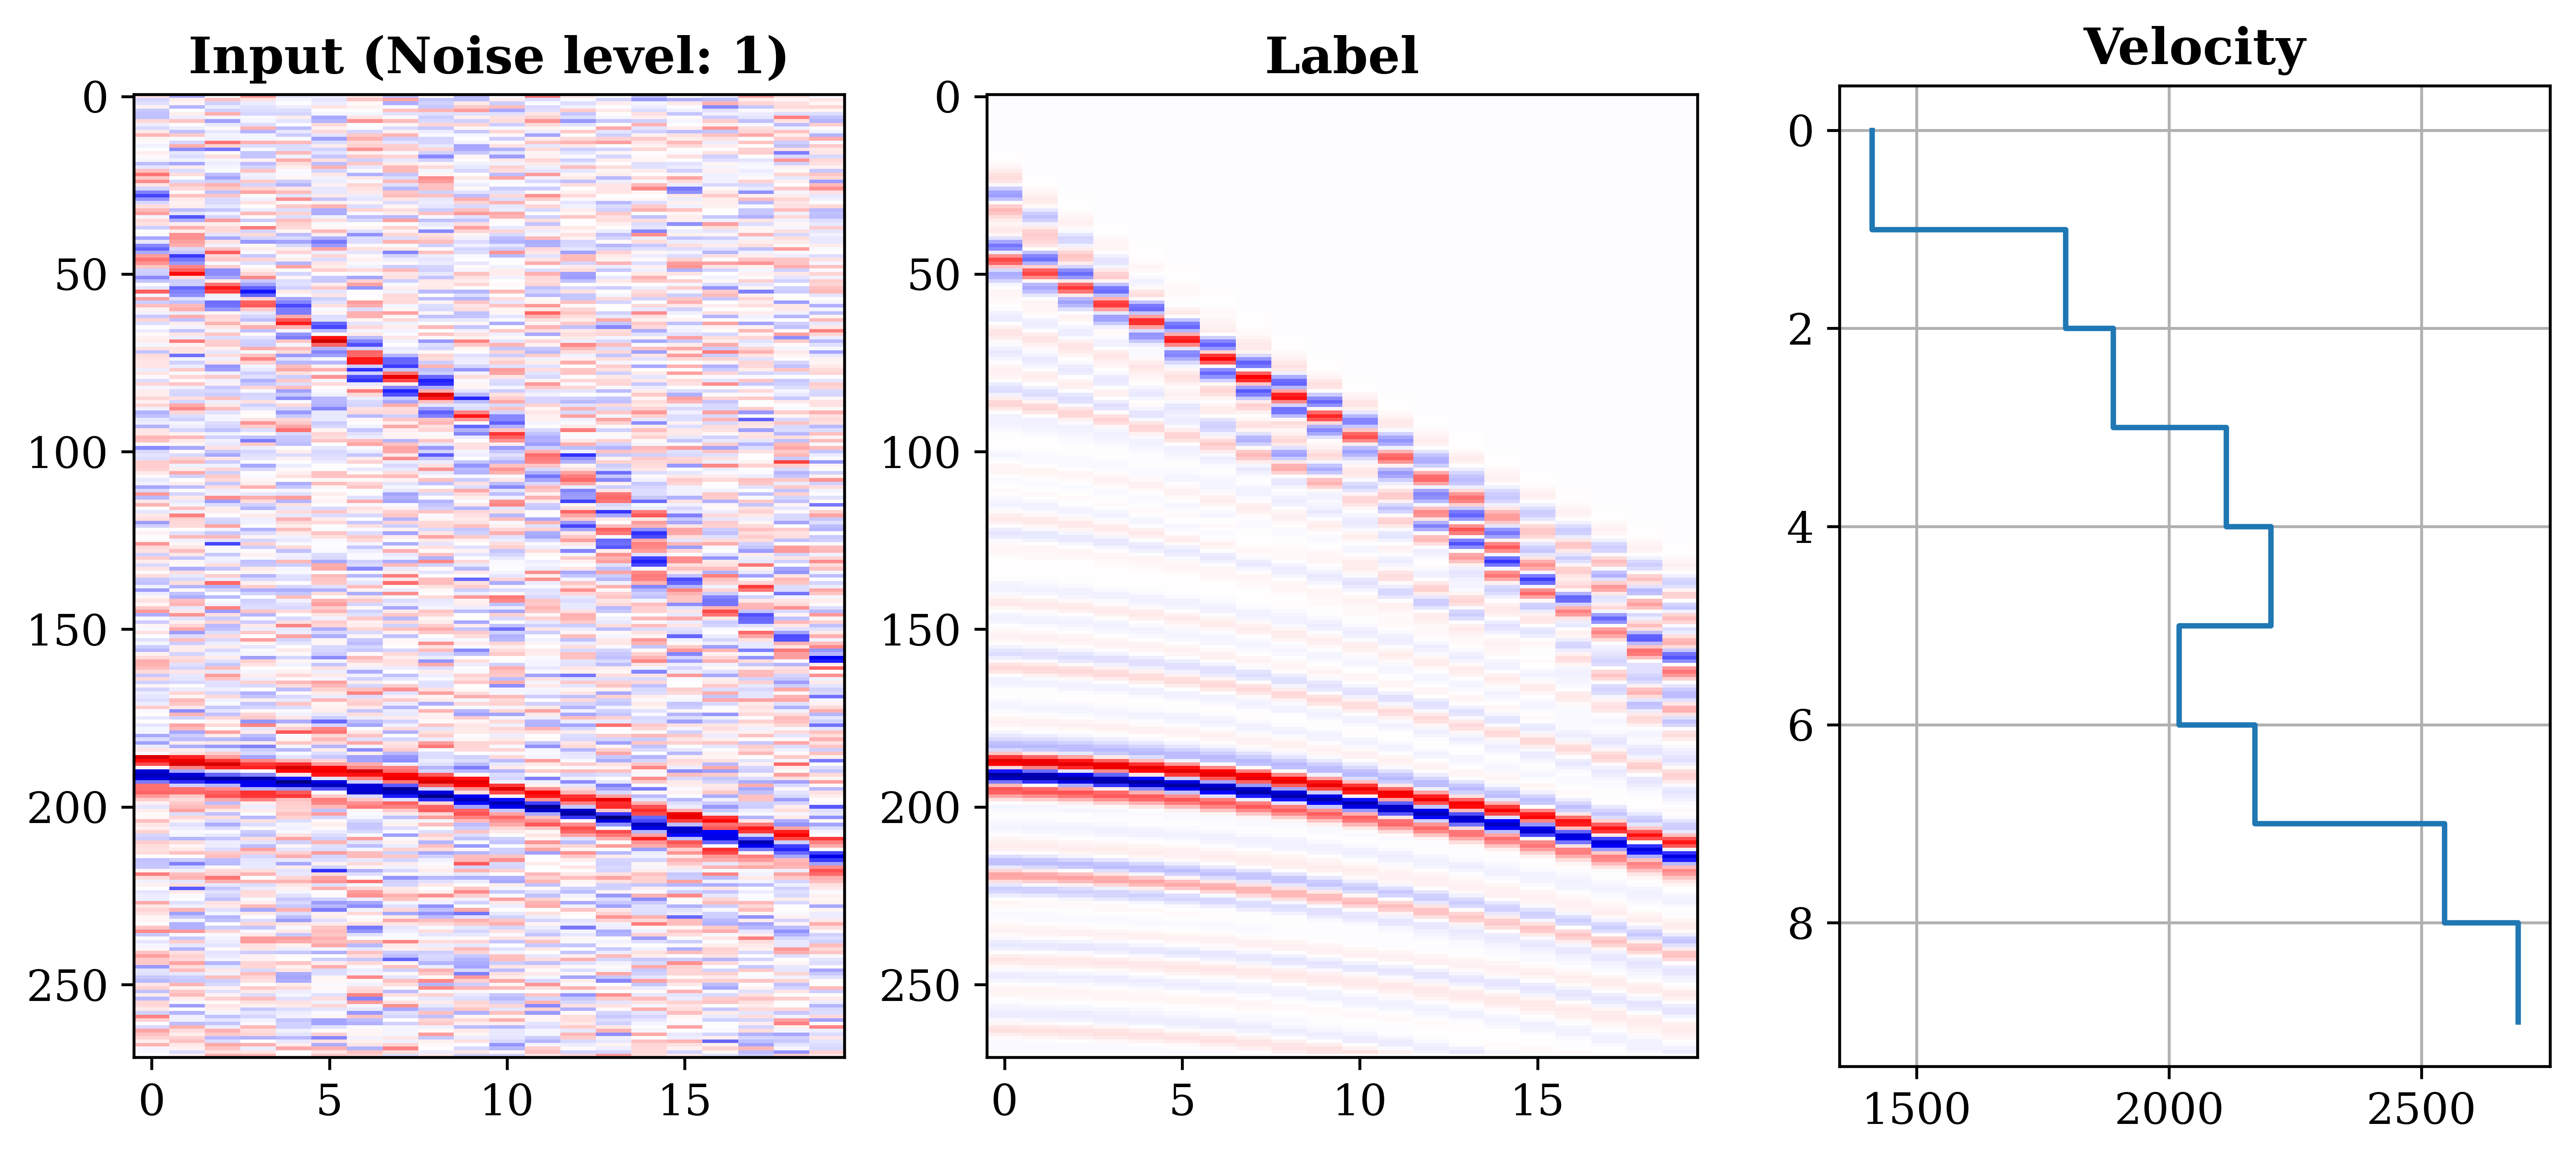

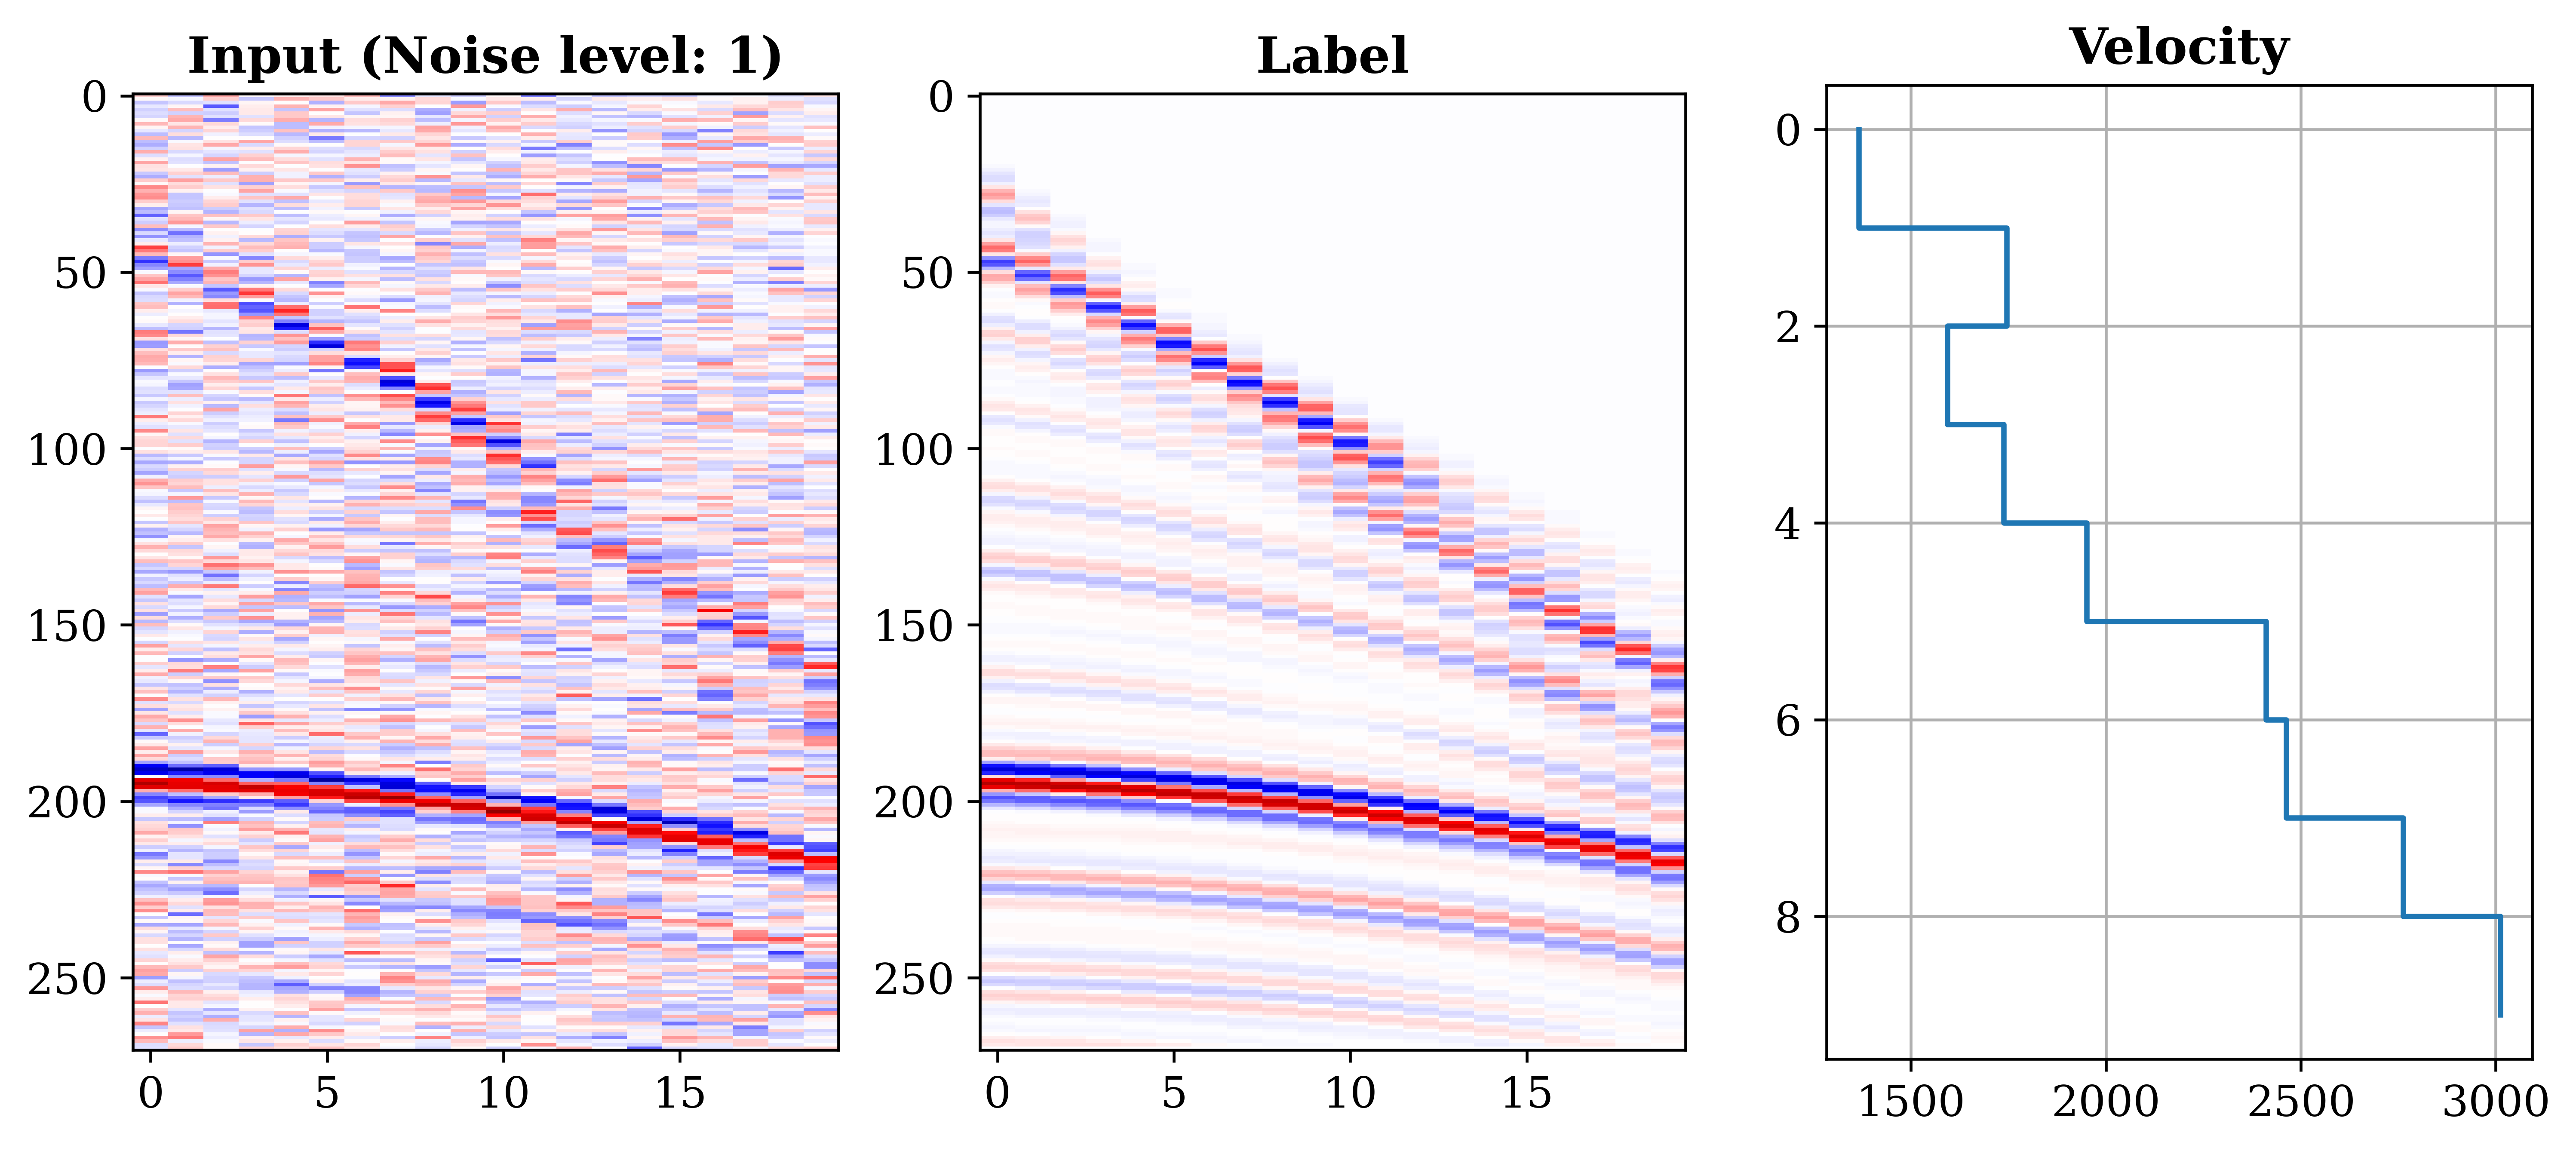

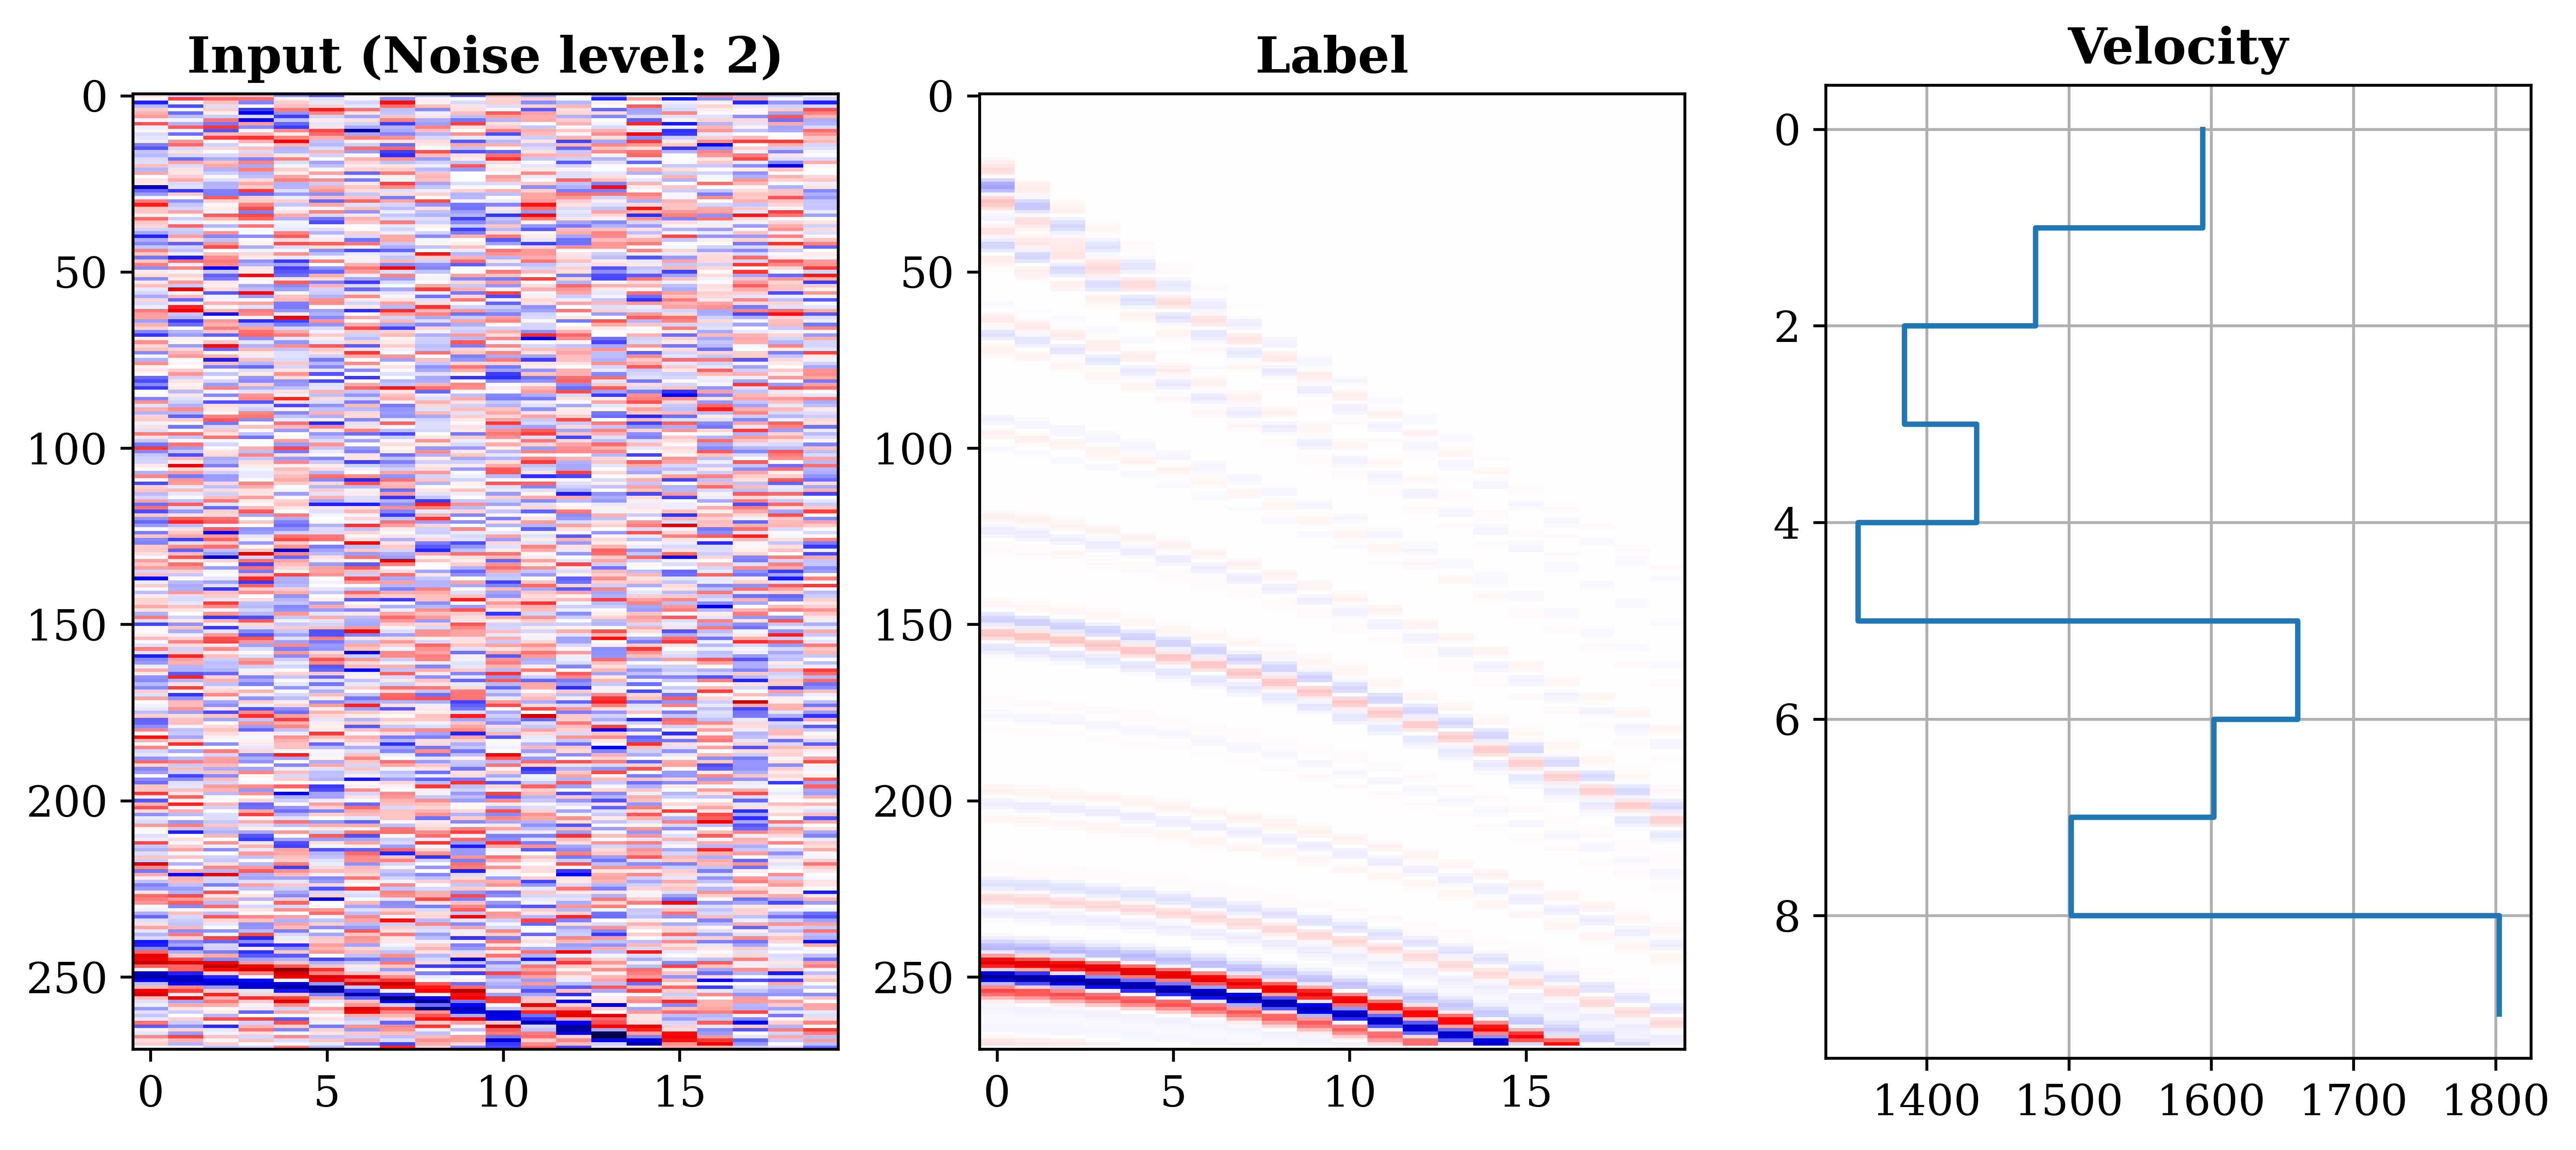

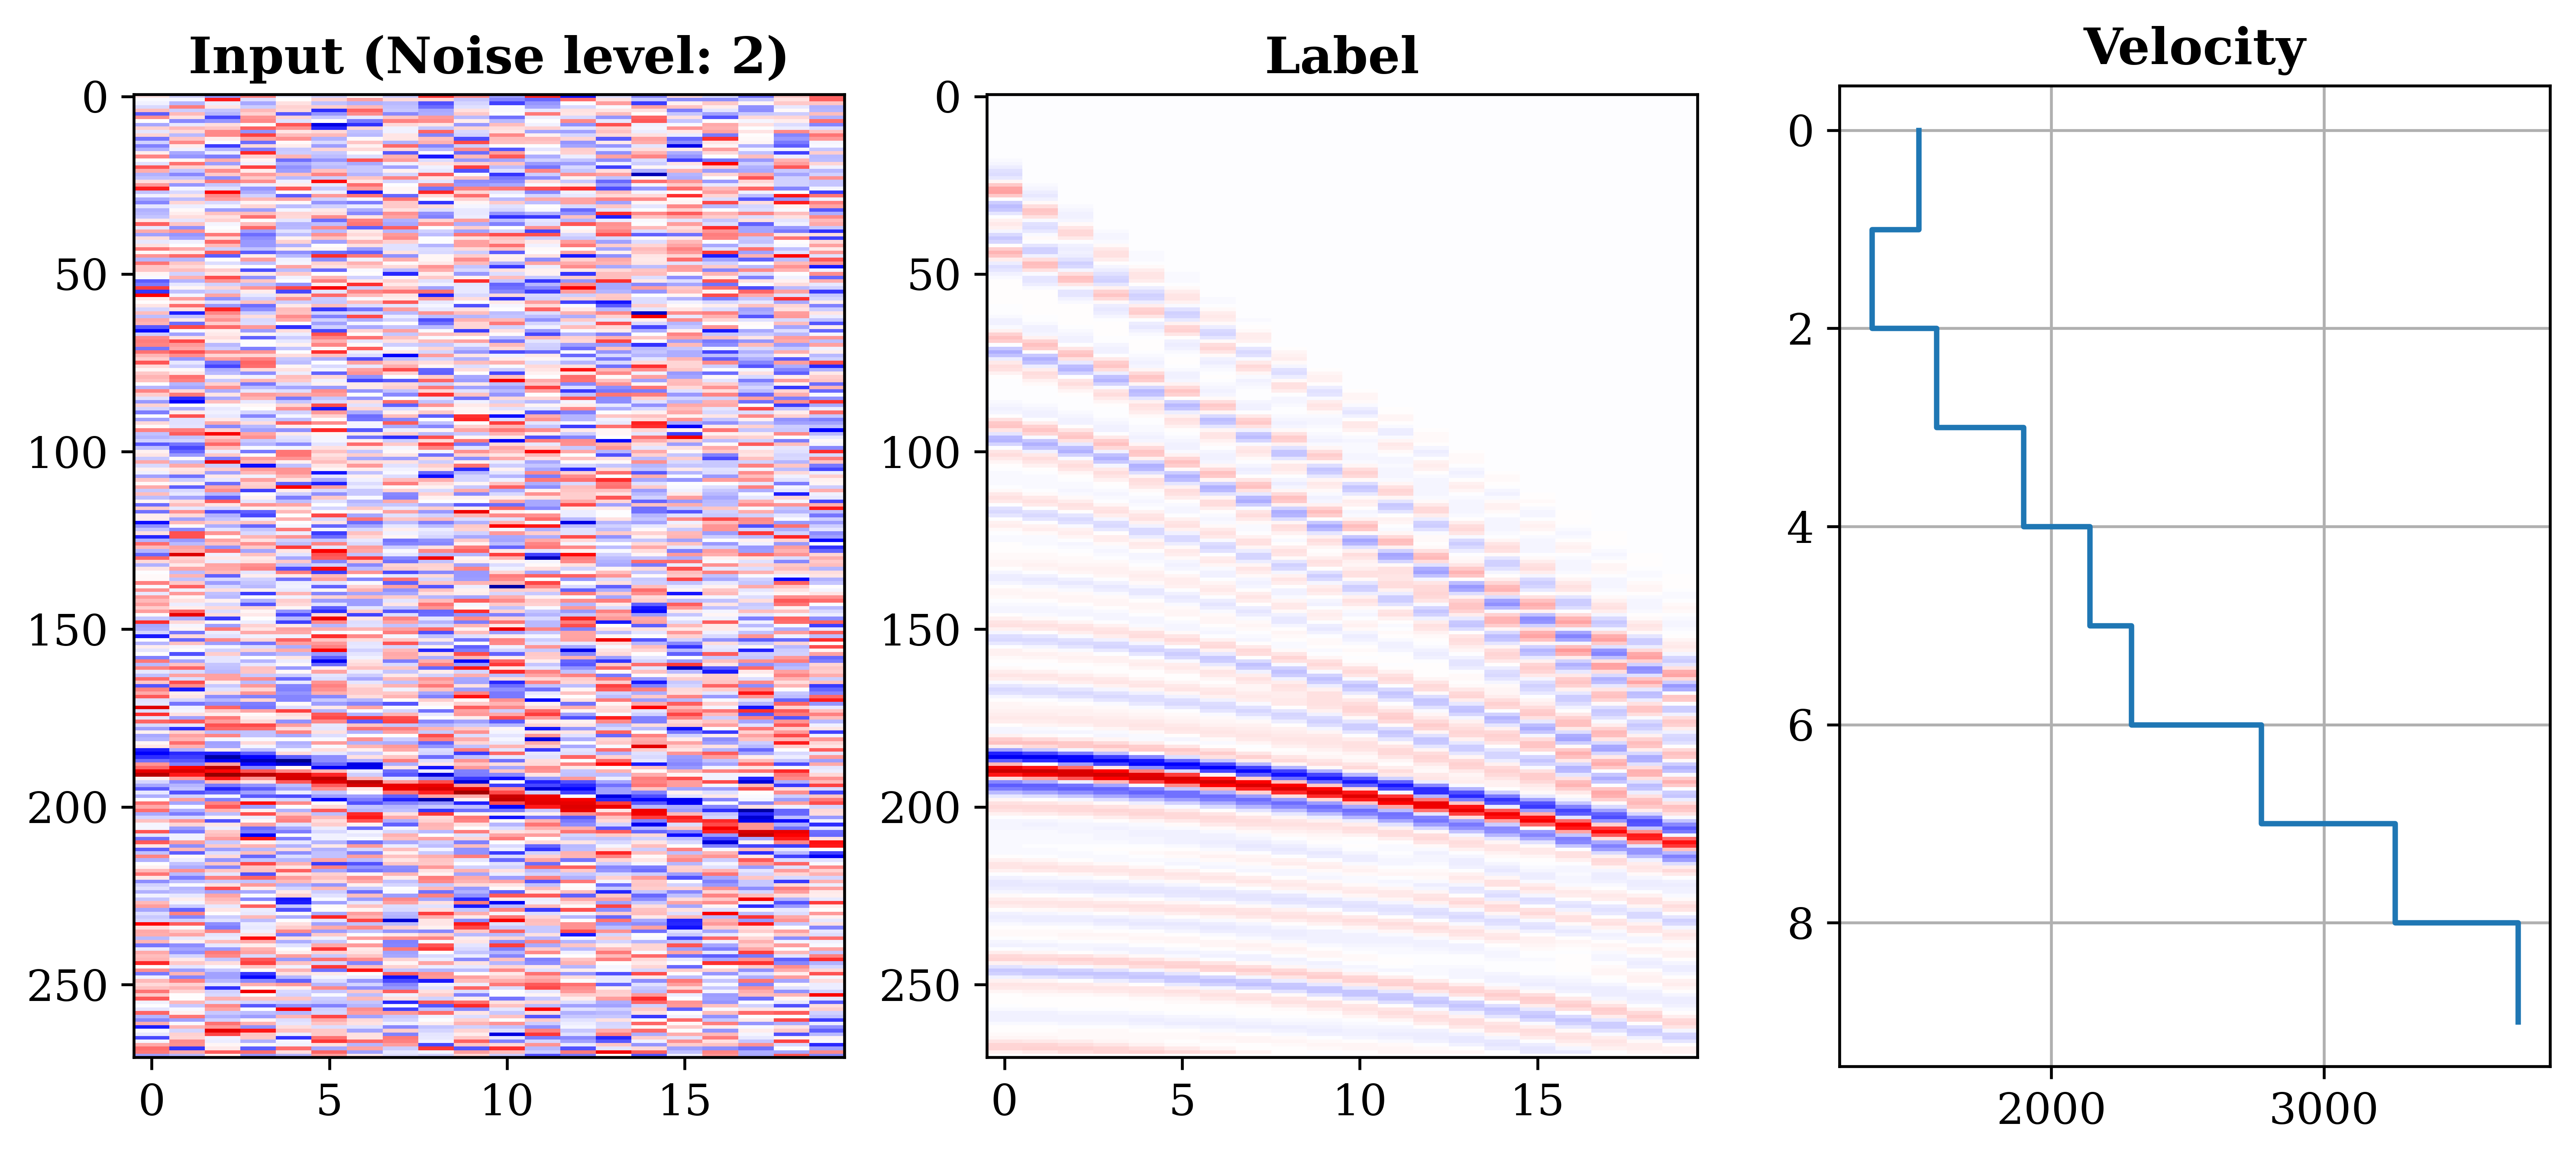

In [44]:
# Training data

idx =  torch.randint(train_data.encodings['inputs_embeds'].shape[0], (4,))

for inputs_embeds, labels, noise_lvl, vel in zip(train_data.encodings['inputs_embeds'][idx], 
                                                 train_data.encodings['labels'][idx], 
                                                 train_data.encodings['noise_lvl'][idx],
                                                 train_data.encodings['vel'][idx]):
    f, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].imshow(inputs_embeds.swapaxes(0, 1) - inputs_embeds.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[0].set_title("Input (Noise level: {})".format(int(noise_lvl)))
    ax[1].imshow(labels.swapaxes(0, 1) - labels.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[1].set_title("Label")
    ax[2].step(np.pad(vel, (0, 1), 'edge'), np.arange(vel.shape[-1] + 1))
    ax[2].invert_yaxis()
    ax[2].set_title("Velocity")
    ax[2].grid()

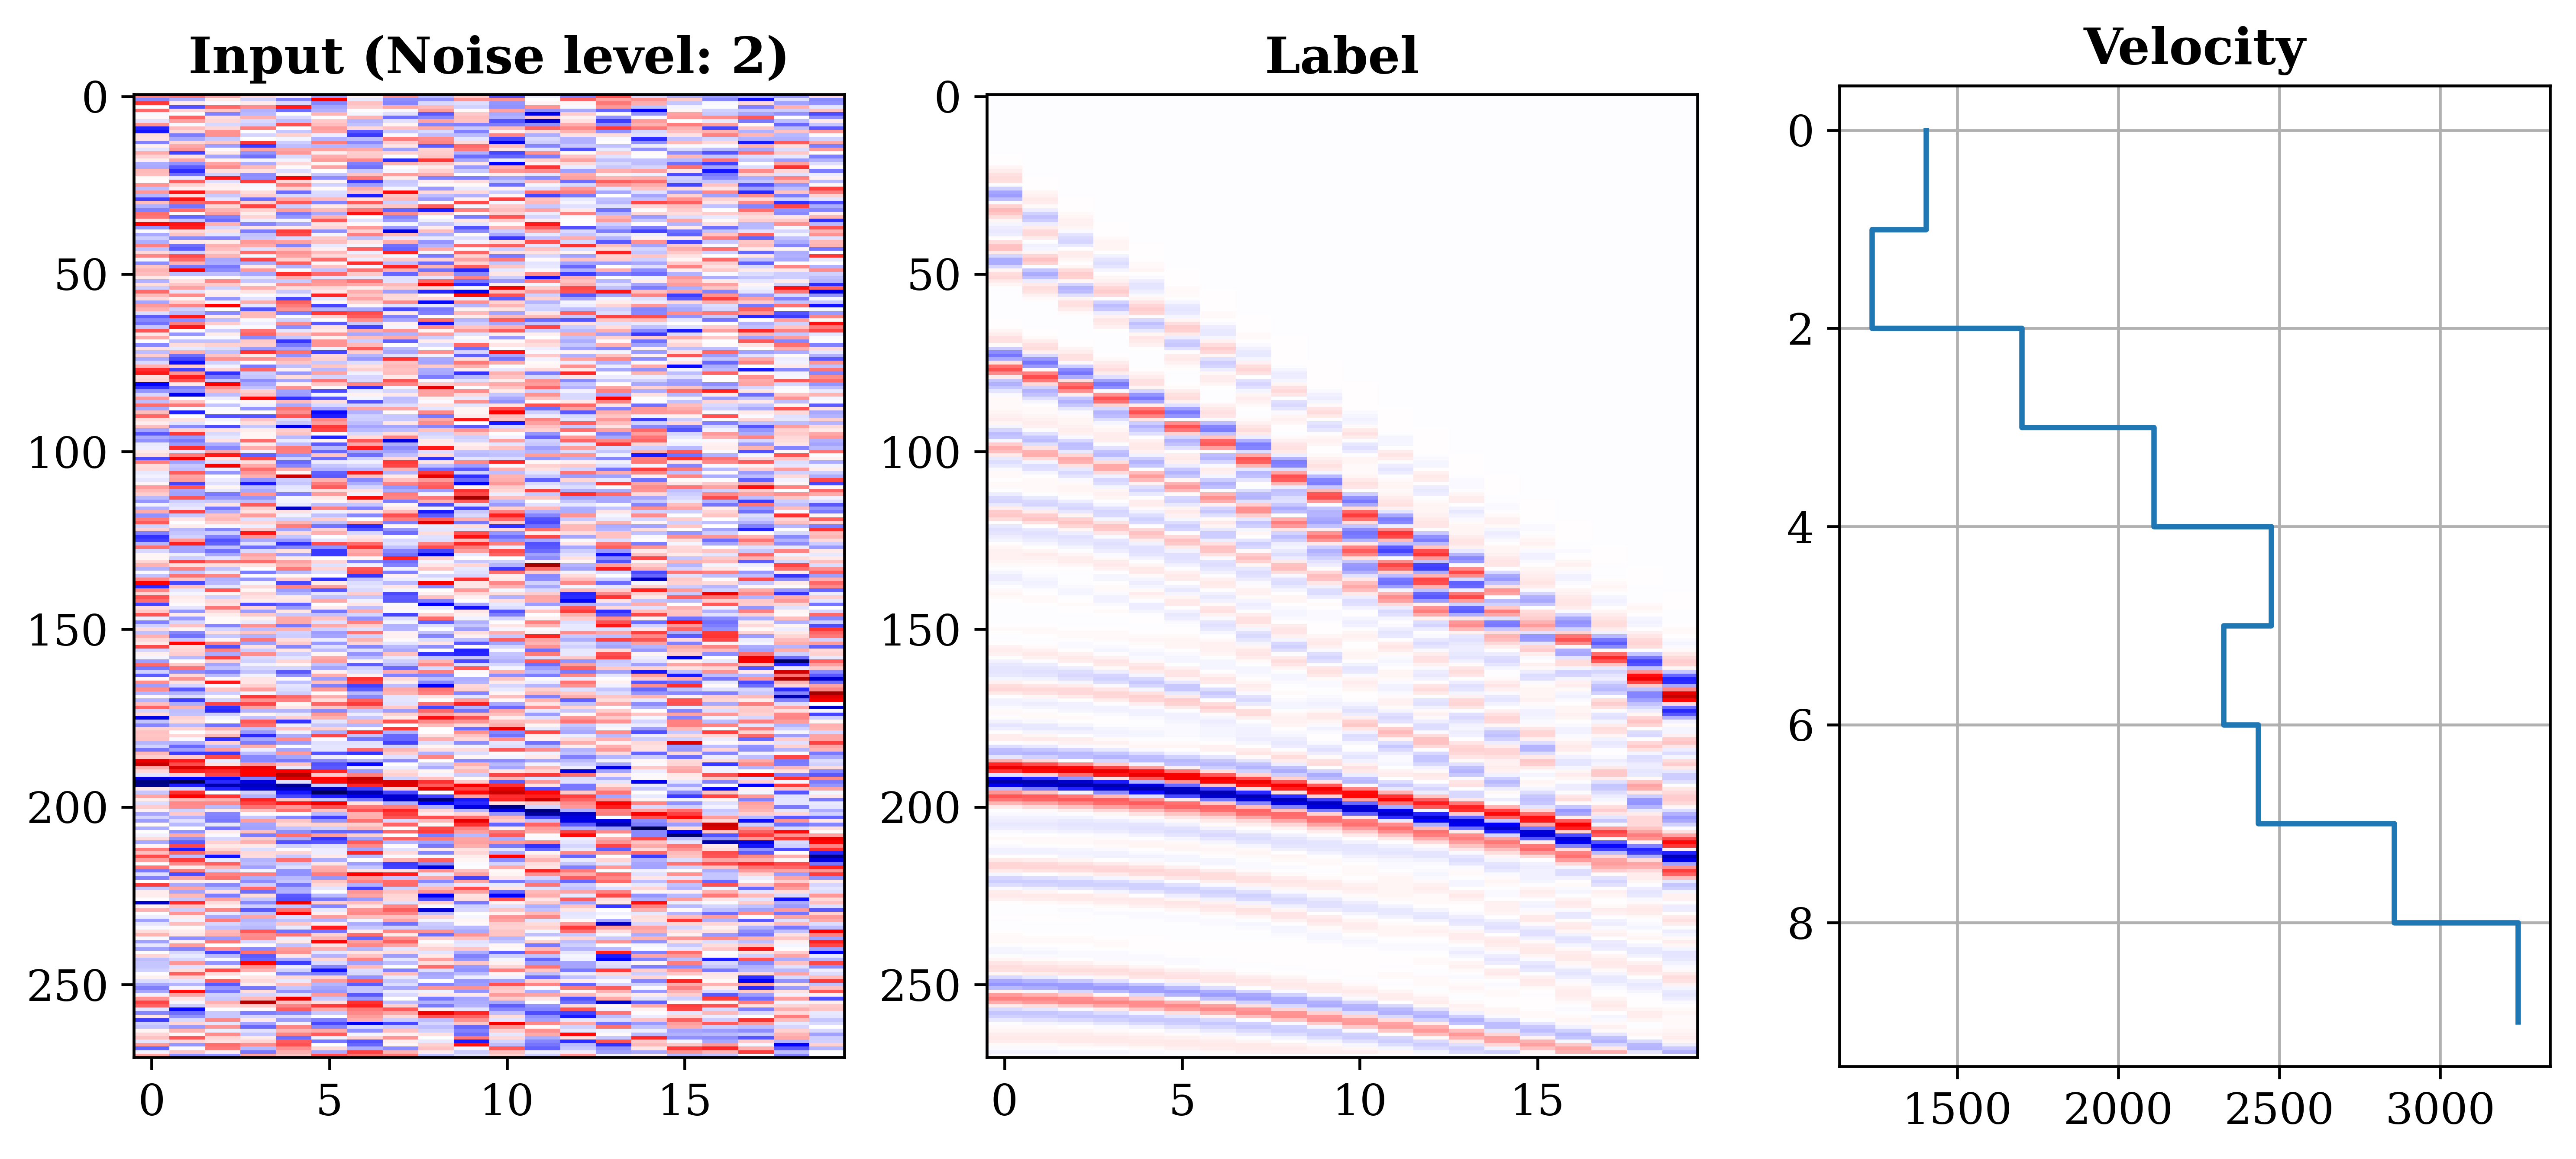

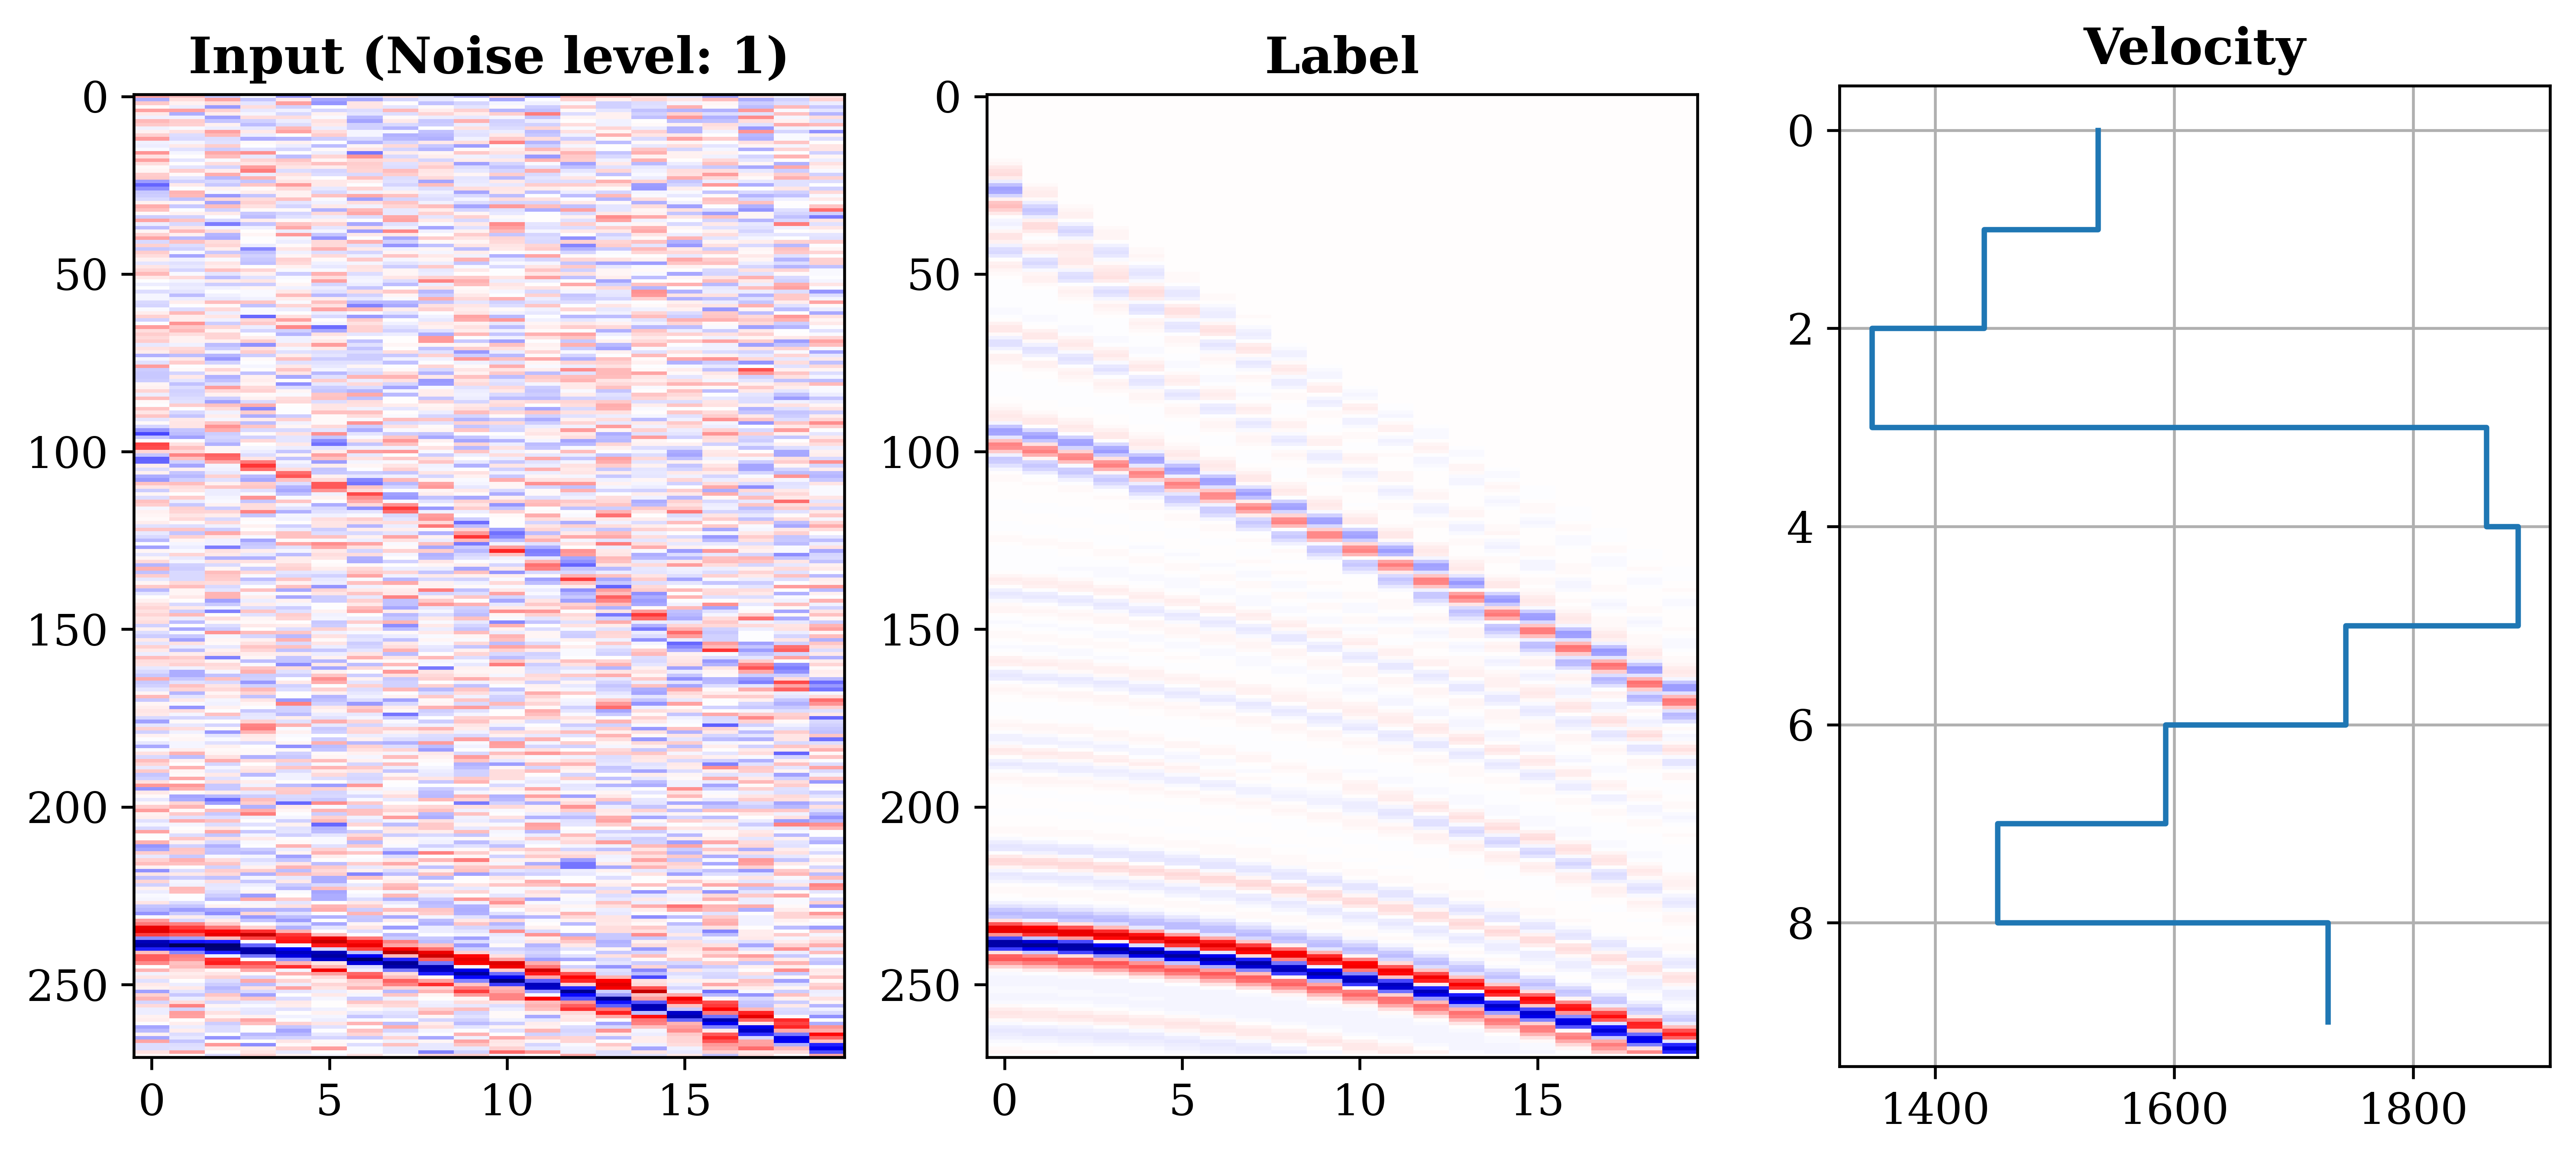

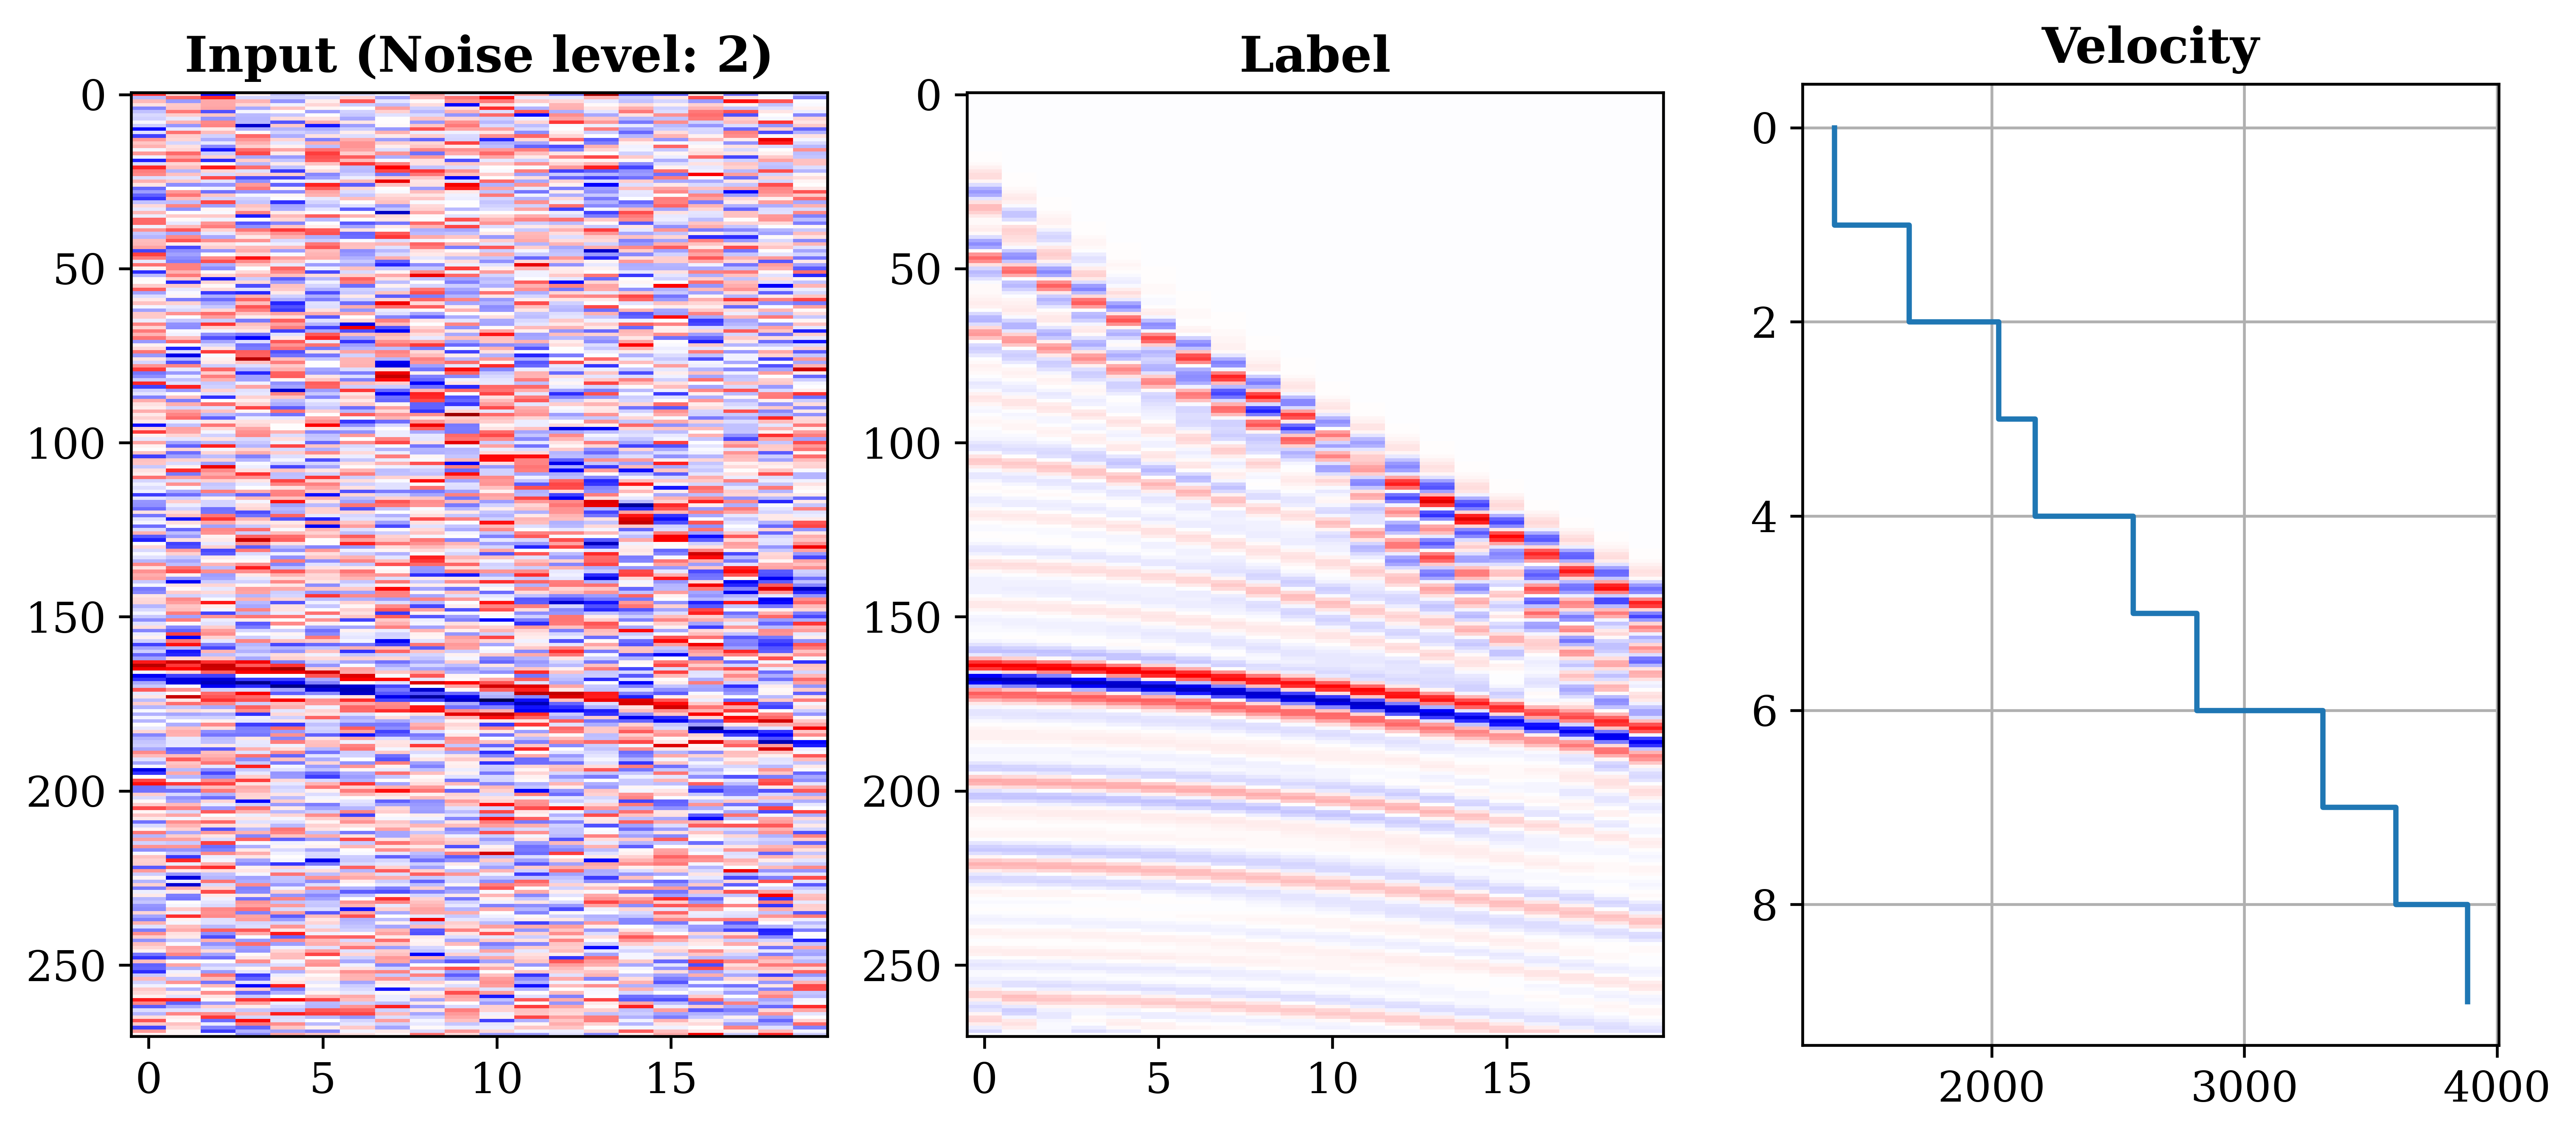

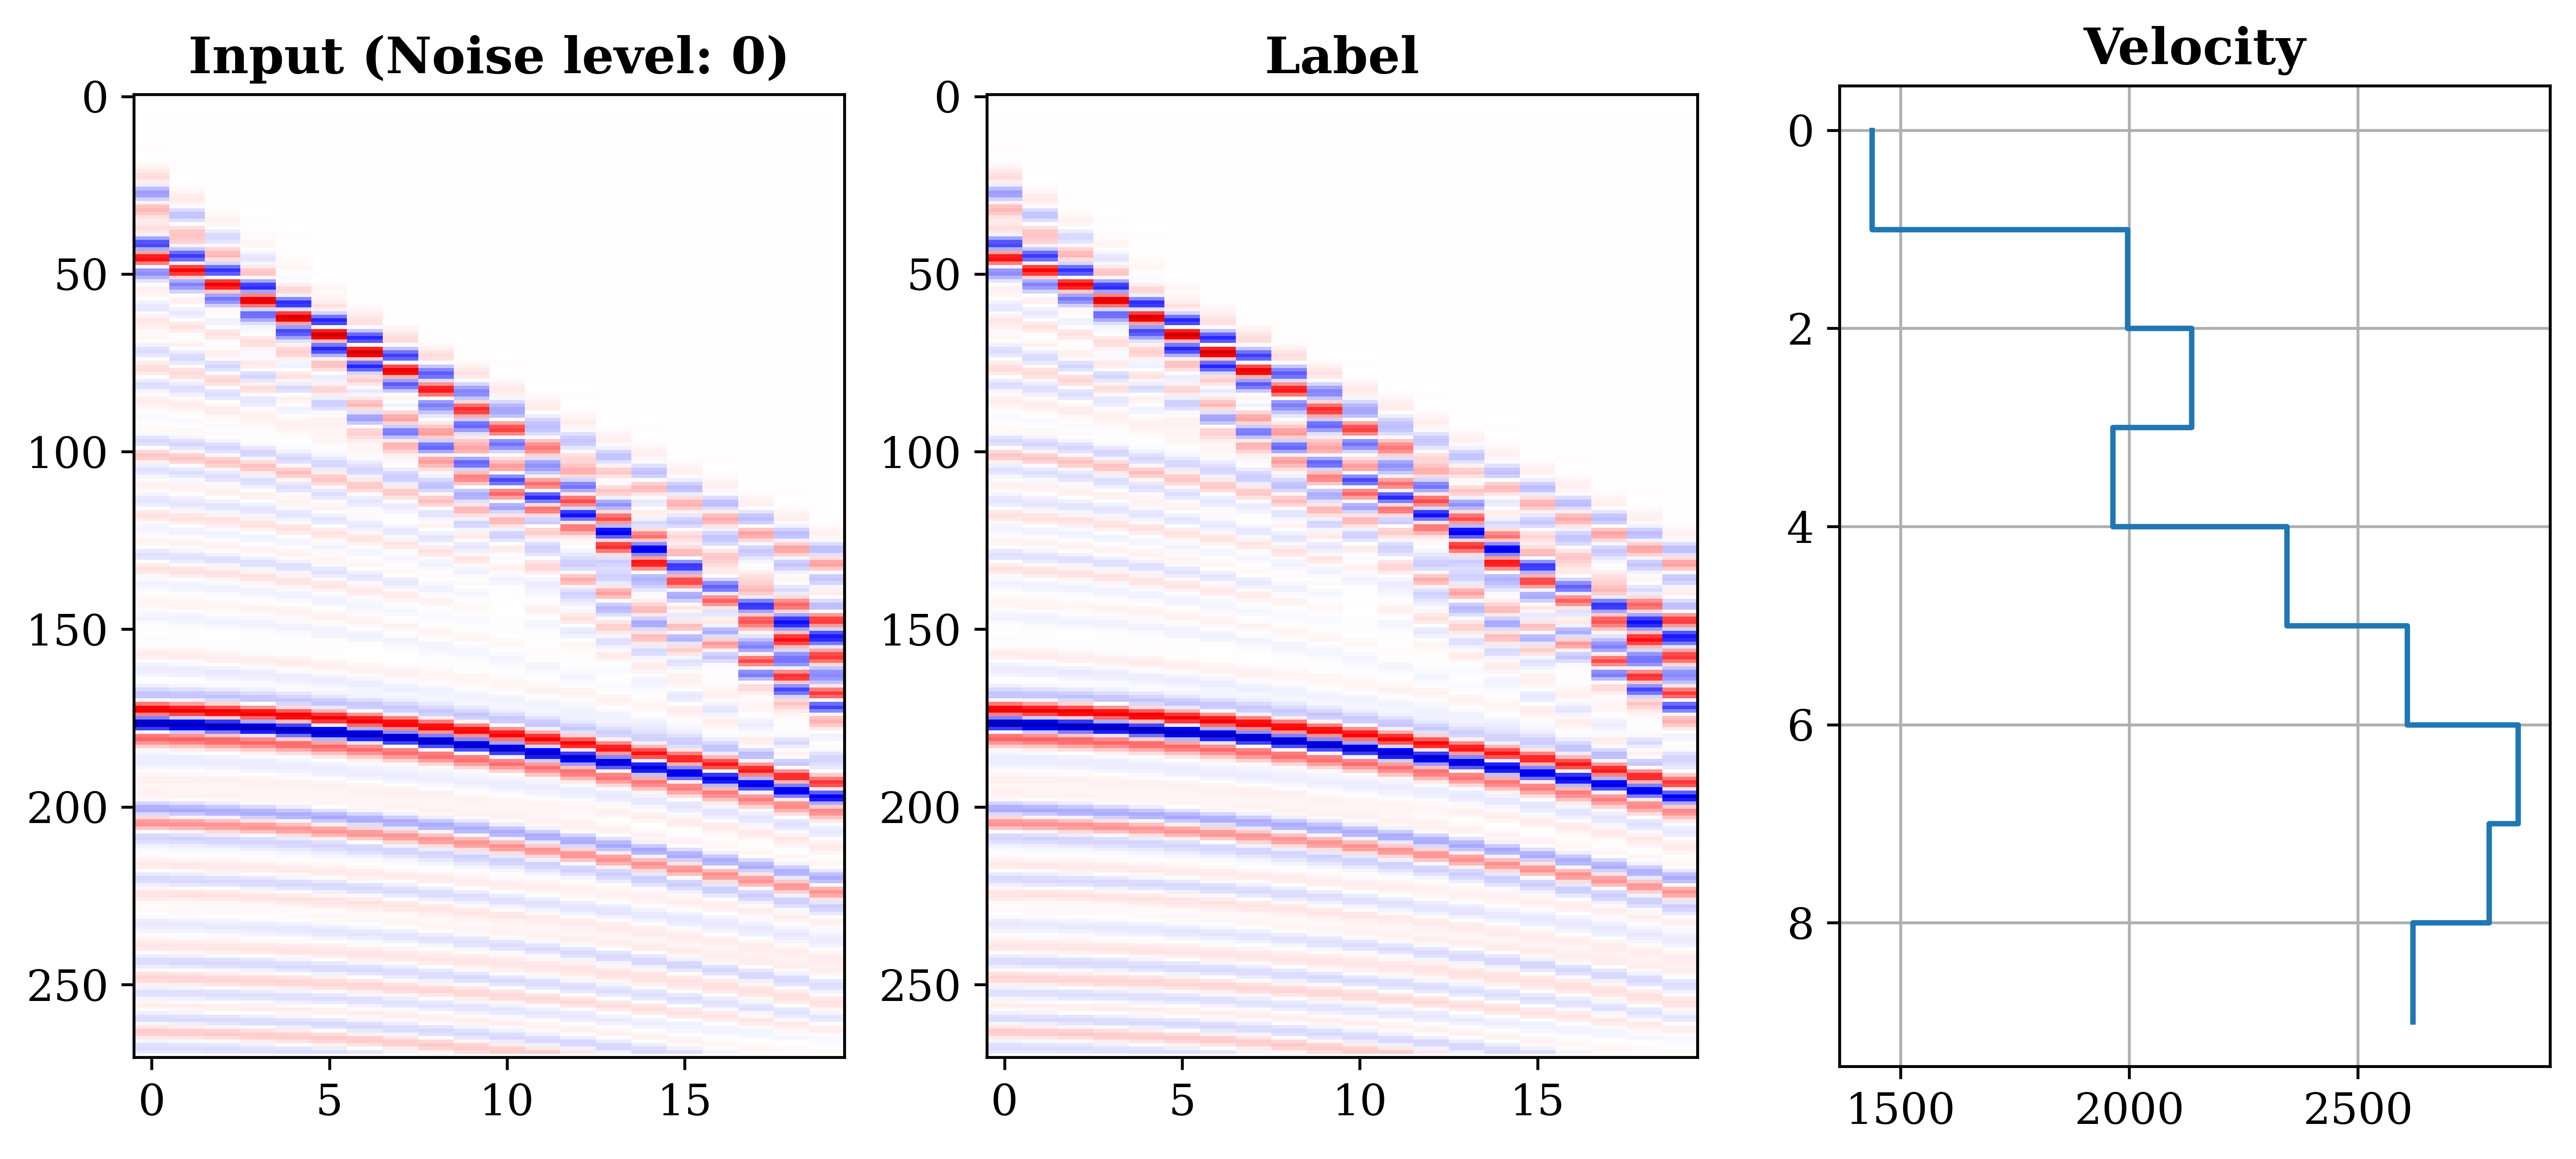

In [45]:
# Testing data

idx =  torch.randint(test_data.encodings['inputs_embeds'].shape[0], (4,))

for inputs_embeds, labels, noise_lvl, vel in zip(test_data.encodings['inputs_embeds'][idx], 
                                                 test_data.encodings['labels'][idx], 
                                                 test_data.encodings['noise_lvl'][idx],
                                                 test_data.encodings['vel'][idx]):
    f, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].imshow(inputs_embeds.swapaxes(0, 1) - inputs_embeds.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[0].set_title("Input (Noise level: {})".format(int(noise_lvl)))
    ax[1].imshow(labels.swapaxes(0, 1) - labels.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[1].set_title("Label")
    ax[2].step(np.pad(vel, (0, 1), 'edge'), np.arange(vel.shape[-1] + 1))
    ax[2].invert_yaxis()
    ax[2].set_title("Velocity")
    ax[2].grid()

### Re-check dimension

We applied x 2 (polarity reversal) times of augmentation to each sample. Therefore, the total number of each of training and testing dataset must have been expanded 2 times than the original.

In [40]:
print("Training data shape: ", train_data.encodings['inputs_embeds'].shape)
print("Testing data shape: ", test_data.encodings['inputs_embeds'].shape)

Training data shape:  torch.Size([1200, 20, 271])
Testing data shape:  torch.Size([300, 20, 271])


### Save dataset

In [42]:
parent_dir = "./data/finetune"

if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)
    torch.save(train_data, os.path.join(parent_dir, "train_data.pt"))
    torch.save(test_data, os.path.join(parent_dir, "test_data.pt"))
    print("Saved successfully")
elif os.path.exists(parent_dir):
    check = input("Directory exist, overwrite? (y/n)")
    if check == 'y':
        torch.save(train_data, os.path.join(parent_dir, "train_data.pt"))
        torch.save(test_data, os.path.join(parent_dir, "test_data.pt"))
        print("Saved successfully")
    else:
        print("Saving failed")
else:
    print("Saving failed")

Saved successfully


## References

Harsuko, R., and T. Alkhalifah, 2022, Storseismic: An approach to pre-train a neural network to store seismic data features: 83rd EAGE Annual Conference & Exhibition, European Association of Geoscientists & Engineers, 1–5.